Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" and remove every line containing the expression: "raise ..." (if you leave such a line your code will not run).

Do not remove any cell from the notebook you downloaded. You can add any number of cells (and remove them if not more necessary).

Do not leave any variable initialized to None.

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebook!!!

## Make sure to name your notebook file (.ipynb) correctly:
### - LAB6_GaussianProcesses_NAMESURNAME_ID (E.g. : LAB6_GaussianProcesses_MARIOROSSI_2204567)

## Fill in your name, surname and id number (numero matricola) below:

In [1]:
NAME = "NIHAL SURI"
ID_number = int("2141819")

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

---

Main topics:
- Gaussian Processes Regression
- Effects of kernel parameters on reconstructed function
- Marginal Likelihood optimization

In this lab you will learn how to use Gaussian Process Regression (GPR) to approximate an unknown function $f$ from noisy measures $f+\epsilon$. You will experience how changes in the kernel parameters affect the reconstructed function. Eventually you will find the best kernel parameters according to Log Marginal Likelihood (LML) optimization.

In [2]:
%matplotlib inline
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ipywidgets import *

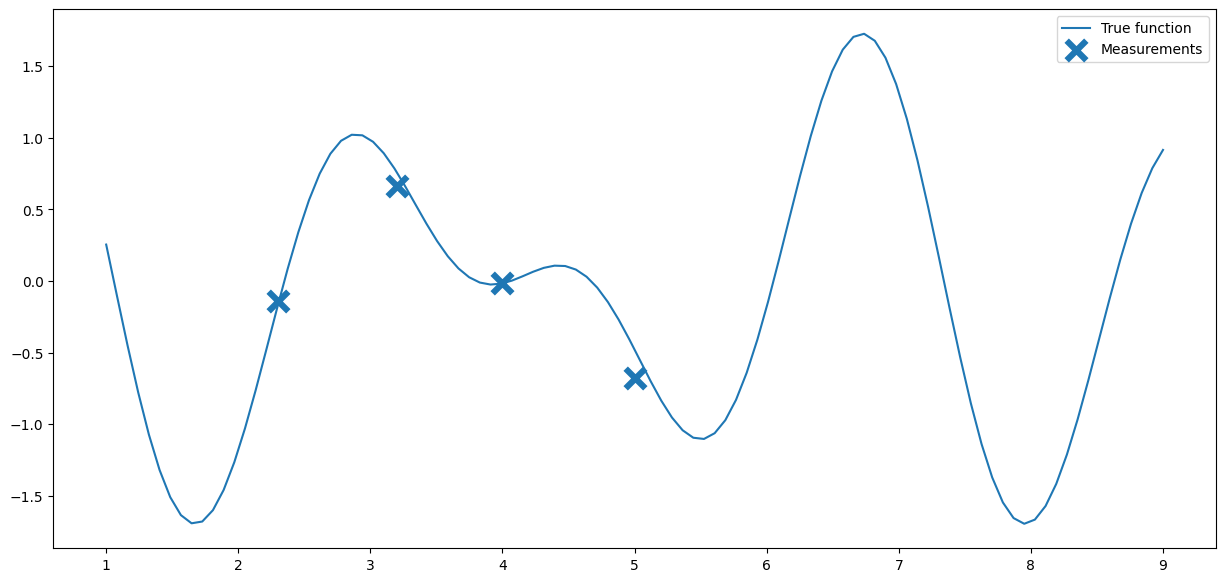

In [3]:
# Define the function to be regressed
def f(x):
    return np.sin(x*2 + 1.) + 0.8 * np.sin(x*3)

x_domain = np.linspace(1,9, 100).reshape(-1,1) # not training, but entire function
y_domain_true = f(x_domain) #

sigma_meas = 0.1
x_train = np.array([2.3, 3.2, 4., 5.]).reshape(-1,1)
y_train = f(x_train) + np.random.normal(0., sigma_meas, x_train.shape)

plt.figure(figsize=(15,7))
plt.plot(x_domain, y_domain_true, label='True function')
plt.scatter(x_train, y_train, marker='x', s=10, linewidth=20, label='Measurements')
plt.legend()

In [4]:
# TODO 1
def plot_GP(gp : GaussianProcessRegressor, x_domain, y_domain_true):
    # assume to be already fitted
    gp_pred_mean = gp.predict(gp.X_train_, return_std=False)

    # Predict using GPR model using x_domain and returning the standard deviation of the predictions (have a look at the documentation)
    y_pred_mean_domain, y_pred_std_domain = None, None
    # YOUR CODE HERE
    y_pred_mean_domain, y_pred_std_domain = gp.predict(x_domain, return_std=True)

    # Sample from the posterior distribution (have a look at the documentation)
    posterior_samples = None
    # YOUR CODE HERE
    posterior_samples = gp.sample_y(x_domain, 1).squeeze(axis=1)

    # Sample from the prior distribution
    # shape of the function that we can sample from
    gp_forPrior = GaussianProcessRegressor(kernel=gp.kernel_, alpha=gp.alpha, optimizer=None)
    prior_samples=gp_forPrior.sample_y(x_domain, 5)

    #plots
    fig, axes = plt.subplots(1,3, figsize=(15,7))

    axes[0].errorbar(x=gp.X_train_.reshape(-1,), y=gp.y_train_.reshape(-1,), yerr=1.96*np.sqrt(gp.alpha),linestyle="None",
                     marker='x',label='Measurements with C.I.')
    axes[0].fill_between(x_domain.reshape(-1,),
                - 1.96 * np.sqrt(gp.kernel_.get_params()['k1__constant_value']),
                + 1.96 * np.sqrt(gp.kernel_.get_params()['k1__constant_value']),
                alpha=0.2, label='95% confidence interval', color='blue')
    axes[0].plot(x_domain, prior_samples, color='red')

    handles, labels = axes[0].get_legend_handles_labels()
    patch = mpatches.Patch(color='red', label='Function drawn from prior')
    handles.append(patch)

    # plot the legend
    axes[0].legend(handles=handles, loc='upper center')

    axes[1].plot(x_domain, y_domain_true, label='True function')
    axes[1].scatter(gp.X_train_, gp.y_train_, marker='x', s=5, linewidth=20, label='Measurements')
    axes[1].scatter(gp.X_train_, gp_pred_mean, label='Predictions on train data')
    axes[1].plot(x_domain, y_pred_mean_domain, label='Predictions on domain')
    axes[1].fill_between(x_domain.reshape(-1,),
                     (y_pred_mean_domain.reshape(-1,) - 1.96 * y_pred_std_domain).reshape(-1,),
                     (y_pred_mean_domain.reshape(-1,) + 1.96 * y_pred_std_domain).reshape(-1,),
                     alpha=0.2, label='95% confidence interval', color='green')

    axes[2].plot(x_domain, y_domain_true, label='True function')
    axes[2].plot(x_domain, posterior_samples, label='Function drawn from posterior')
    axes[2].fill_between(x_domain.reshape(-1,),
                 (y_pred_mean_domain.reshape(-1,) - 1.96 * y_pred_std_domain).reshape(-1,),
                 (y_pred_mean_domain.reshape(-1,) + 1.96 * y_pred_std_domain).reshape(-1,),
                 alpha=0.2, label='95% confidence interval', color='green')

    axes[1].legend(), axes[2].legend()

    # Compute the RSS/TSS (using sklearn score function)
    x_domain_loss = None
    # YOUR CODE HERE
    x_domain_loss = 1 - gp.score(x_domain, y_domain_true)
    axes[1].set_title(f"RSS/TSS on x_domain {x_domain_loss:.4f}")

### See next cell: Large length scale
Large length scale ($l=10$): the GP with RBF interpolates every datum within a ball of radius $l$ from $x^*$ to make a prediciton on $x^*$, therefore we predict almost a constant function on the range: x_domain (2,6).

The functions sampled from the posterior are very smooth (almost linear) in the inspected range (low complexity).

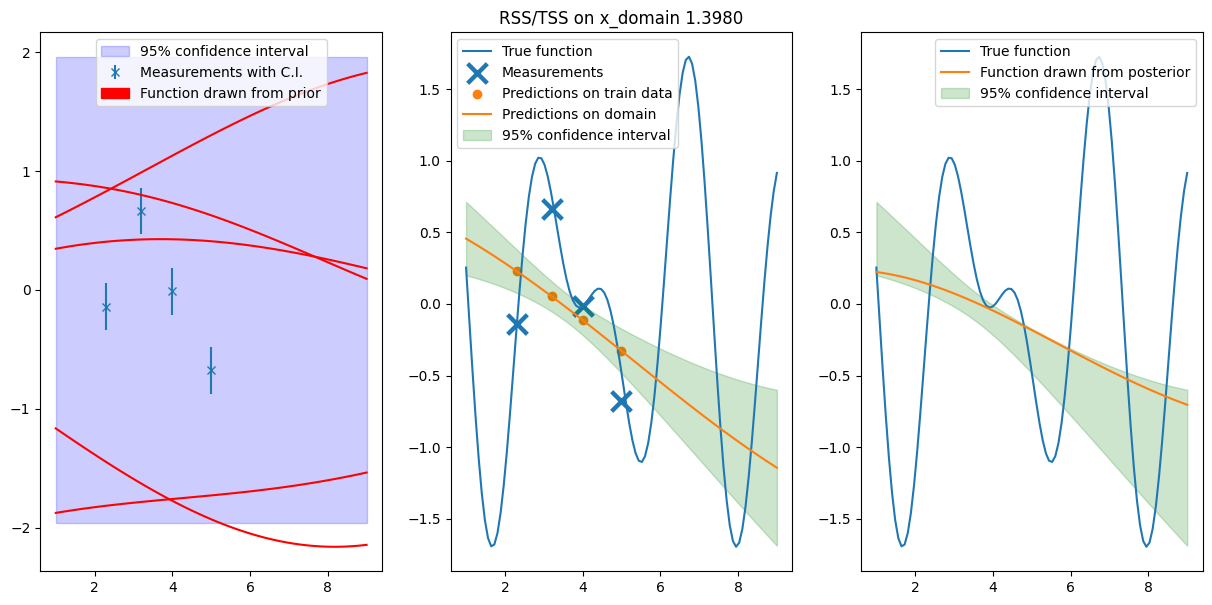

In [5]:
# we assume we know the noise sigma_2
scale_factor, length_scale, sigma_2 = 1., 10., 0.01
# Here we choose the RBF kernel scaled by the factor scale_factor
kernel = scale_factor * RBF(length_scale=length_scale)

# Here we explicitly choose not to optimize the hyperparameters. So that model predictions will depend
# on the hyper parameters we choose (and not the optimal ones found using marginal log likelihood)

gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_2, optimizer=None).fit(x_train, y_train)
plot_GP(gp, x_domain, y_domain_true)

### See next cell: Small length scale
Small length scale (l = $0.1$): GP with RBF never uses more than one point in y_train to predict the output. Note in between the training data the GP predicts identically zero (the prior mean) and a 95% confidence interval of length 1.96 (since the GP prior variance is $k=1$).

The functions sampled from the posterior are not much smooth (high complexity).

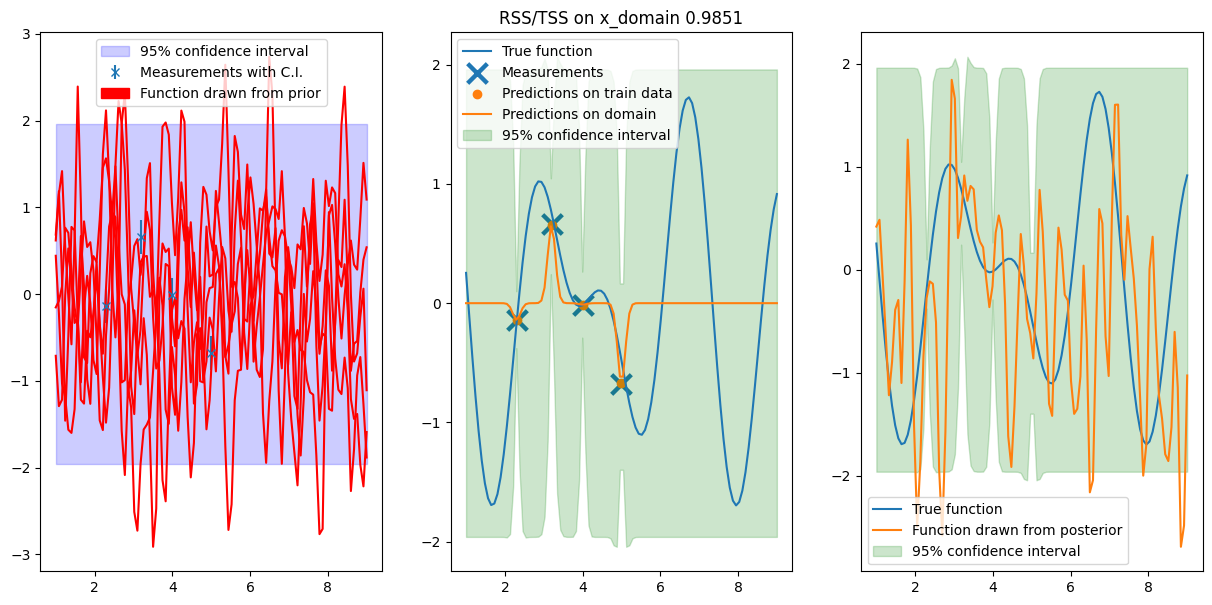

In [6]:
scale_factor, length_scale, sigma_2 = 1., 1e-1, 0.01
kernel = scale_factor * RBF(length_scale=length_scale)
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_2, optimizer=None).fit(x_train, y_train)
plot_GP(gp, x_domain, y_domain_true)

### See next cell: "proper" scale length
Better choice of $l$, the regression function (the mean of the GP) is not overlapped with the true functon but now its shape is "closer" to the true function. Note the samples from the posterior seem to behave better now.

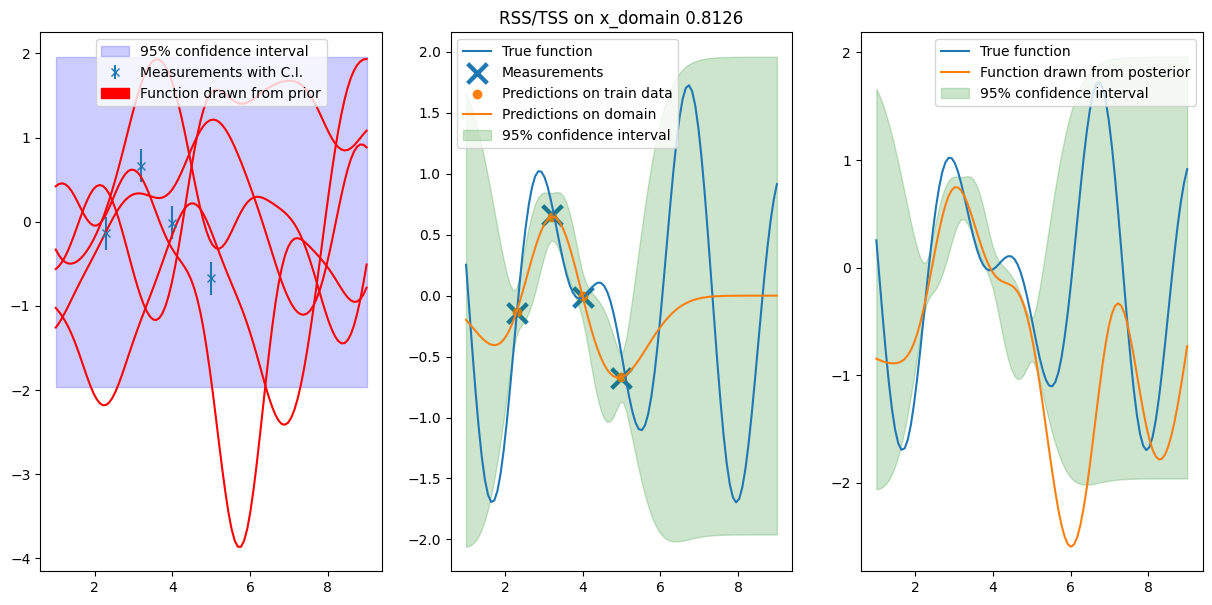

In [7]:
scale_factor, length_scale, sigma_2 = 1., 0.8, 0.01
kernel = scale_factor * RBF(length_scale=length_scale)
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_2, optimizer=None).fit(x_train, y_train)
plot_GP(gp, x_domain, y_domain_true)
# when there are no measurements the CI goes to the one as the origianl function

### TO DO 2
Starting from the same hyper-parameters we used above see what happens when you change both scale_factor and  noise level (sigma_2) separately (first scale factor and the noise level). You need to create a new RBF kernel and new GP for each different situation (see previous cells).

What do you observe? Why, try to justify the behaviour in each situation (intuitively).

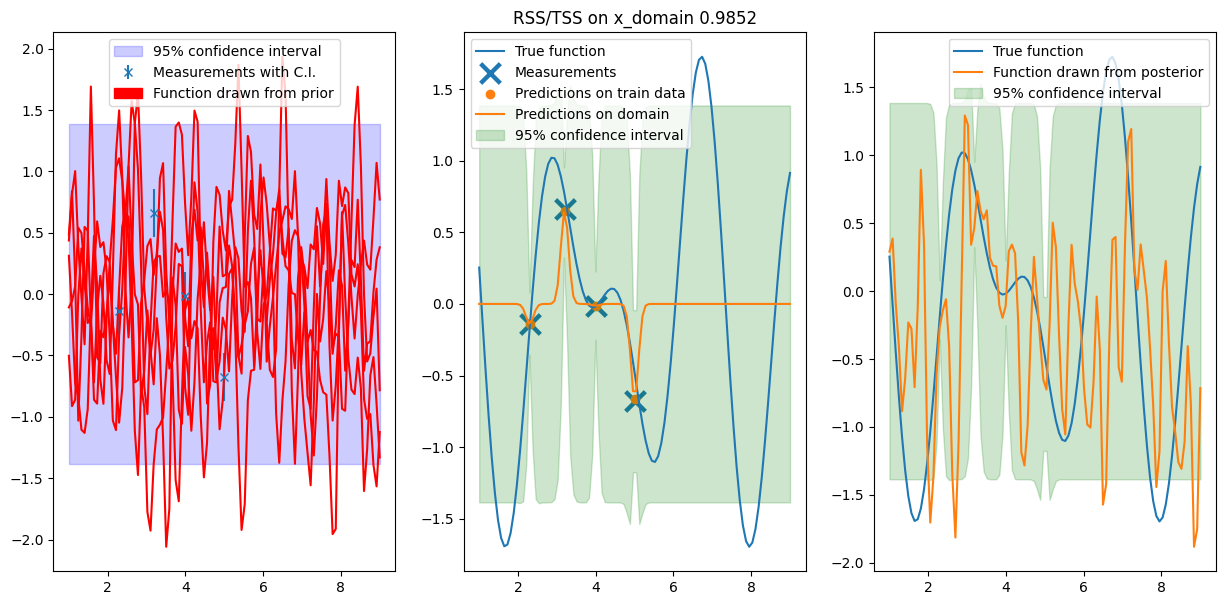

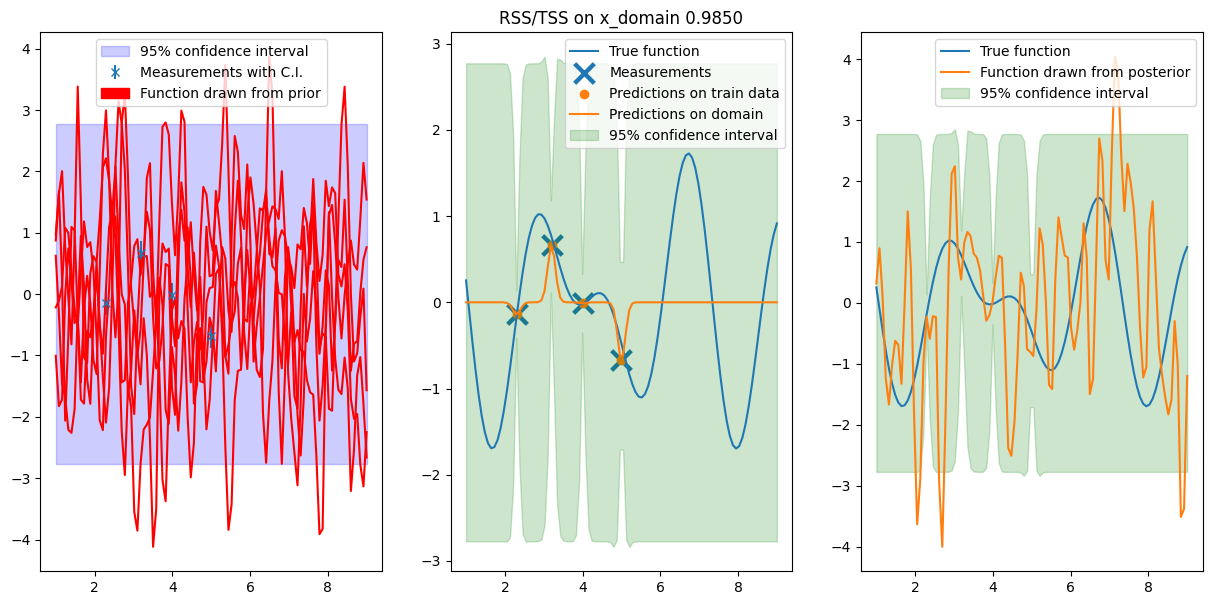

In [8]:
# TODO 2, part 1
# Try different scale factors.

# Fixed hyper-parameters
length_scale, sigma_2 = 1e-1, 0.01

# Change the scale factor
scale_factor = 0.5
# YOUR CODE HERE
kernel = scale_factor * RBF(length_scale=length_scale)
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_2, optimizer=None).fit(x_train, y_train)
plot_GP(gp, x_domain, y_domain_true)

scale_factor = 2
# YOUR CODE HERE
kernel = scale_factor * RBF(length_scale=length_scale)
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_2, optimizer=None).fit(x_train, y_train)
plot_GP(gp, x_domain, y_domain_true)

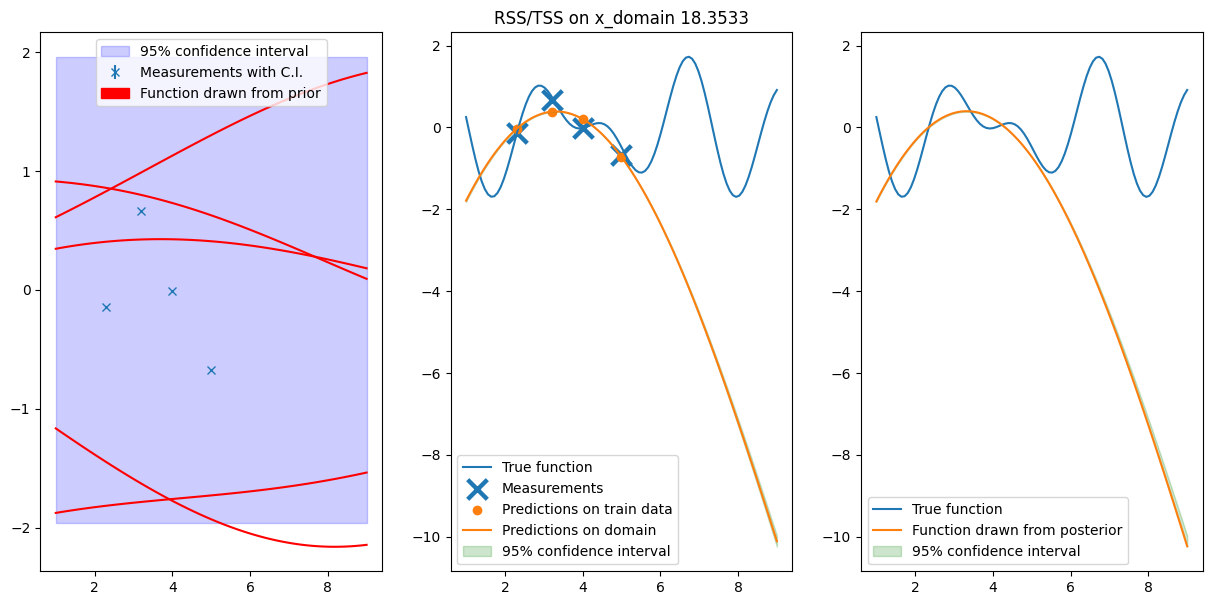

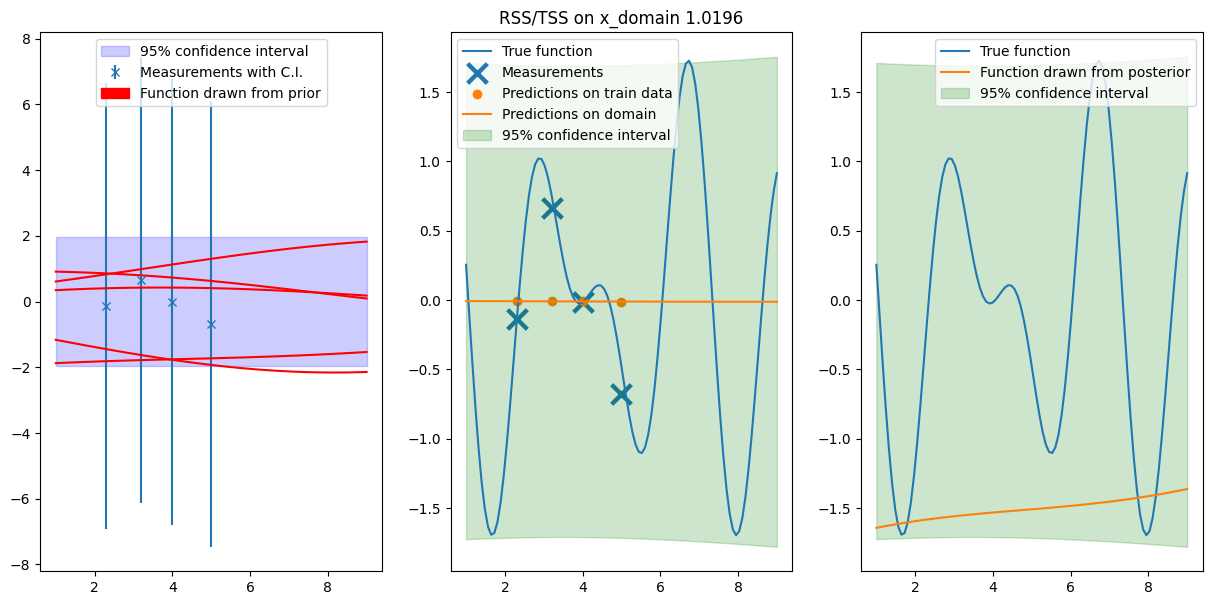

In [9]:
# TODO 2, part 2.
# Now change sigma_2

scale_factor, length_scale = 1., 10.
sigma_2 = 1e-5 #(less than 1e-4)
# YOUR CODE HERE
kernel = scale_factor * RBF(length_scale=length_scale)
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_2, optimizer=None).fit(x_train, y_train)
plot_GP(gp, x_domain, y_domain_true)

sigma_2 = 12  # large (more than 10)
# YOUR CODE HERE
kernel = scale_factor * RBF(length_scale=length_scale)
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_2, optimizer=None).fit(x_train, y_train)
plot_GP(gp, x_domain, y_domain_true)

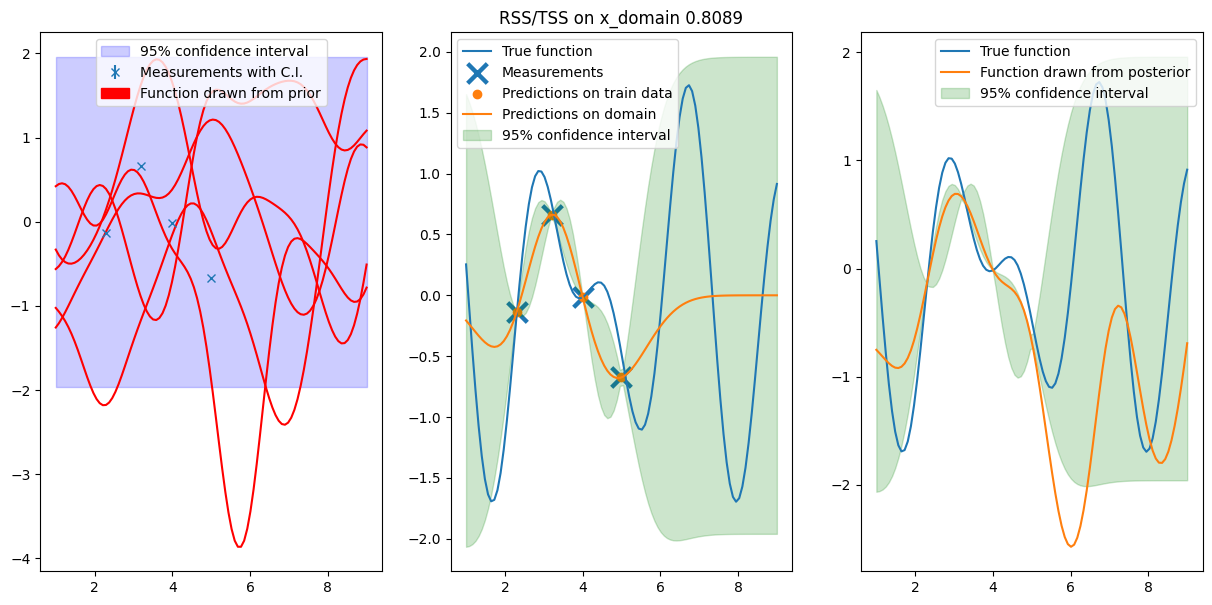

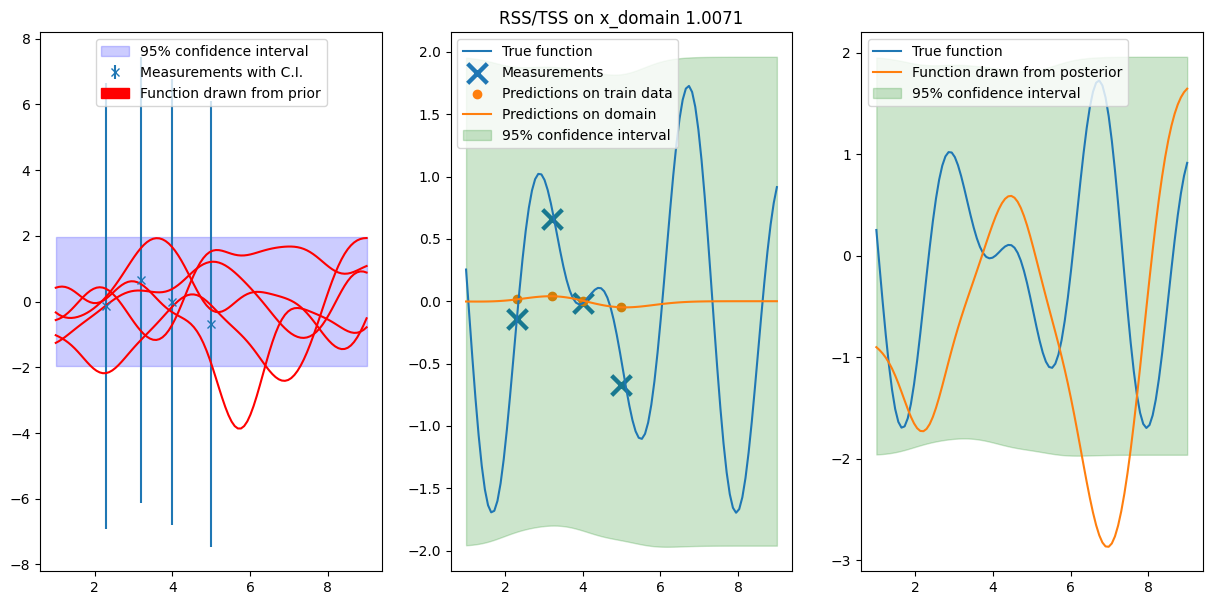

In [10]:
# TODO 2, part 3.
scale_factor, length_scale = 1., 0.8
sigma_2 = 1e-7  # small (less than 1e-6)
# YOUR CODE HERE
kernel = scale_factor * RBF(length_scale=length_scale)
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_2, optimizer=None).fit(x_train, y_train)
plot_GP(gp, x_domain, y_domain_true)

sigma_2 = 12  # large (more than 10)
# YOUR CODE HERE
kernel = scale_factor * RBF(length_scale=length_scale)
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_2, optimizer=None).fit(x_train, y_train)
plot_GP(gp, x_domain, y_domain_true)

# Using more data
We now are going to use more data, so that we should be able to better approximate the underlying function, provided that we choose the correct set of hyper-parameters.


In [11]:
x_train = np.array([2.3, 2.6, 2.7, 3, 3.2,6.4, 6., 7.2, 7.5, 7.8]).reshape(-1,1)
y_train = f(x_train) + np.random.normal(0., sigma_meas, x_train.shape)

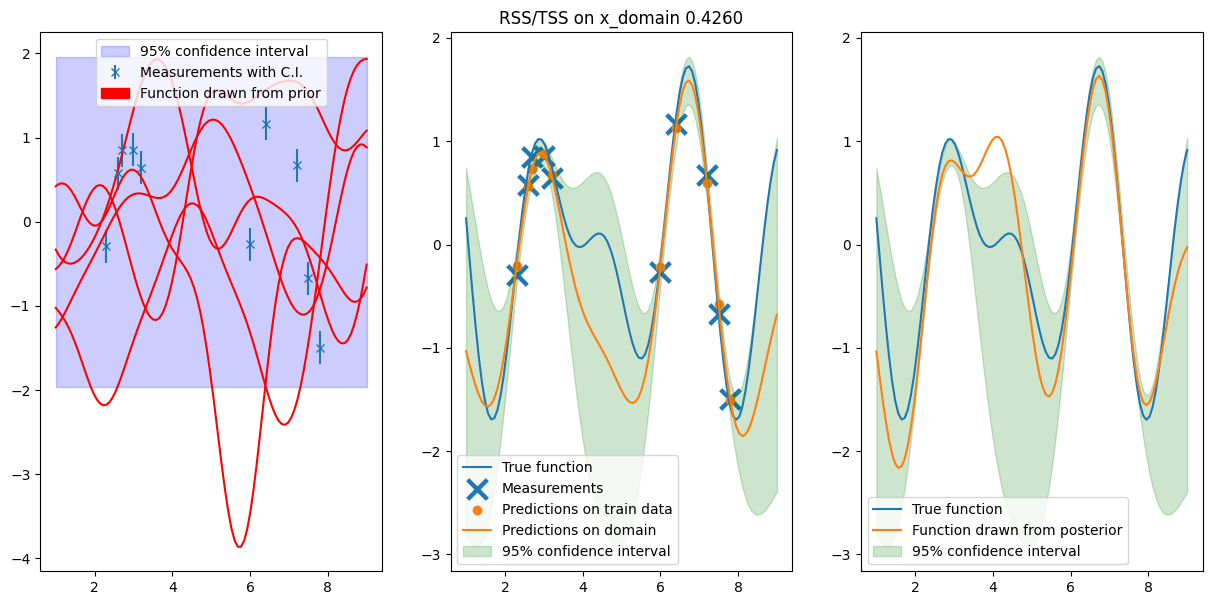

In [12]:
scale_factor, length_scale, sigma_2 = 1., 0.8, 0.01
kernel = scale_factor * RBF(length_scale=length_scale)
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_2, optimizer=None).fit(x_train, y_train)
plot_GP(gp, x_domain, y_domain_true)

### TODO 3: Interective hyper-parameters search
To do, use the following cells (and the sliders) to find the kernel parameters that approximately reproduce the 3 figures below. Try to understand what is happening under the hood.

In [13]:
def update(length_scale=1.0, scale_factor=0.5, sigma_2=0.1):
    kernel = scale_factor * RBF(length_scale=length_scale)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_2, optimizer=None).fit(x_train, y_train)
    y_pred_mean_domain, y_pred_std_domain = gp.predict(x_domain, return_std=True)
    plot_GP(gp, x_domain, y_domain_true)

# Variance of GP noise
alpha = 0.01 # This is not known a priori and should be close to the actual std for the noisy measurements
interact(update, length_scale=(1e-3, 5, 0.1), scale_factor=(1e-3, 10, 0.1), sigma_2=fixed(alpha))

# No need to provide code in this cell, just play with sliders
# YOUR CODE HERE


interactive(children=(FloatSlider(value=1.0, description='length_scale', max=5.0, min=0.001), FloatSlider(valu…

<function __main__.update(length_scale=1.0, scale_factor=0.5, sigma_2=0.1)>

In [14]:
# TODO 4:
# Now you can change the value of sigma_2, what has changed?
interact(update, length_scale=(1e-3, 5, 0.1), scale_factor=(1e-3, 10, 0.1), sigma_2=(1e-5, 10, 0.1))

interactive(children=(FloatSlider(value=1.0, description='length_scale', max=5.0, min=0.001), FloatSlider(valu…

<function __main__.update(length_scale=1.0, scale_factor=0.5, sigma_2=0.1)>

## What if data are less corrupted by noise?

In [15]:
# TODO 5:
# Find the best set of kernel parameters by hand with a new dataset (in which the noise level is lower than before)
# You can try to increase the number of measurements by uncommenting line 7 and 8 (you can change num_data).

# Create new measurements using larger std
x_train_less_noise = np.array([2.3, 2.6, 2.7, 3, 3.2,6.4, 6., 7.2, 7.5, 7.8]).reshape(-1,1)
# num_data = 40
# x_train_less_noise = np.random.uniform(2,6, num_data).reshape(-1,1) # If you want to try with more measures
y_train_less_noise = f(x_train_less_noise) + np.random.normal(0., sigma_meas * 0.1, x_train_less_noise.shape)

def update(length_scale=1.0, scale_factor=1.0, sigma_2=0.1):
    kernel = scale_factor * RBF(length_scale=length_scale)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_2, optimizer=None).fit(x_train_less_noise, y_train_less_noise)
    plot_GP(gp, x_domain, y_domain_true)

# Find (by trial and error) the best set of kernel parameters with GP noise variance (alpha) fixed to
# the true value (not known in practice)
interact(update, length_scale=(1e-3, 5, 0.1), scale_factor=(1e-3, 10, 0.1), sigma_2=fixed((sigma_meas*0.1)**2))

# Find (by trial and error) the best set of kernel parameters (now alpha can be choosen)
interact(update, length_scale=(1e-3, 5, 0.1), scale_factor=(1e-3, 10, 0.1), sigma_2=(1e-5, 10, 0.1))

# No need to insert any line in this cell, just play with sliders
# YOUR CODE HERE


interactive(children=(FloatSlider(value=1.0, description='length_scale', max=5.0, min=0.001), FloatSlider(valu…

interactive(children=(FloatSlider(value=1.0, description='length_scale', max=5.0, min=0.001), FloatSlider(valu…

<function __main__.update(length_scale=1.0, scale_factor=1.0, sigma_2=0.1)>

{'k1': 0.974**2, 'k2': RBF(length_scale=0.466), 'k1__constant_value': 0.9485834637776802, 'k1__constant_value_bounds': (1e-05, 100000.0), 'k2__length_scale': 0.4657259874232584, 'k2__length_scale_bounds': (1e-05, 100000.0)}


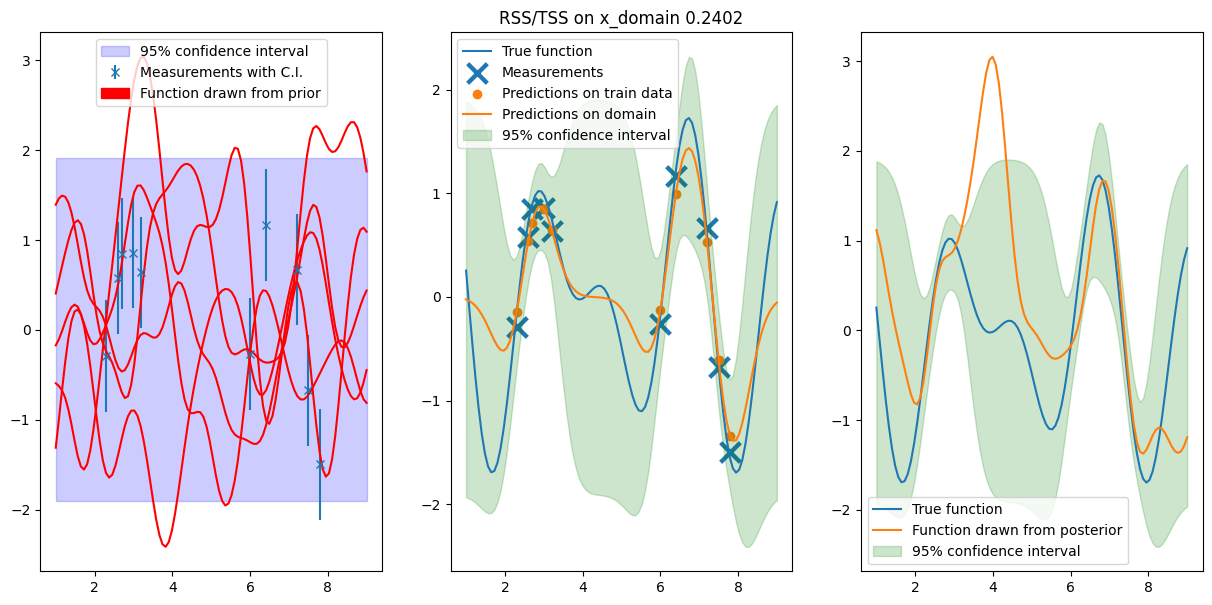

In [16]:
# TODO 6:
# Optimize Log Marginal Likelihood to find the optimal value of the kernel parameters, do they correspond to the ones
# you found by hand (low noise dataset)? Note you need to specify the noise level sigma_2
# (try different values, it has a similar role to alpha in the ridge regression, in case of GP regression it can
# be interpreted as the variance of the measurements. Use 'fmin_l_bfgs_b' optimizer.
sigma_2 = 0.1

scale_factor, length_scale = 1., 1.
# YOUR CODE HERE

kernel = scale_factor * RBF(length_scale=length_scale)
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_2, optimizer='fmin_l_bfgs_b').fit(x_train, y_train)

plot_GP(gp, x_domain, y_domain_true)
print(gp.kernel_.get_params())

Stored Kernel Parameters (Log-scale): [-0.0527855  -0.76415783]
Stored Kernel Parameters (linear scale): [0.94858346 0.46572599]


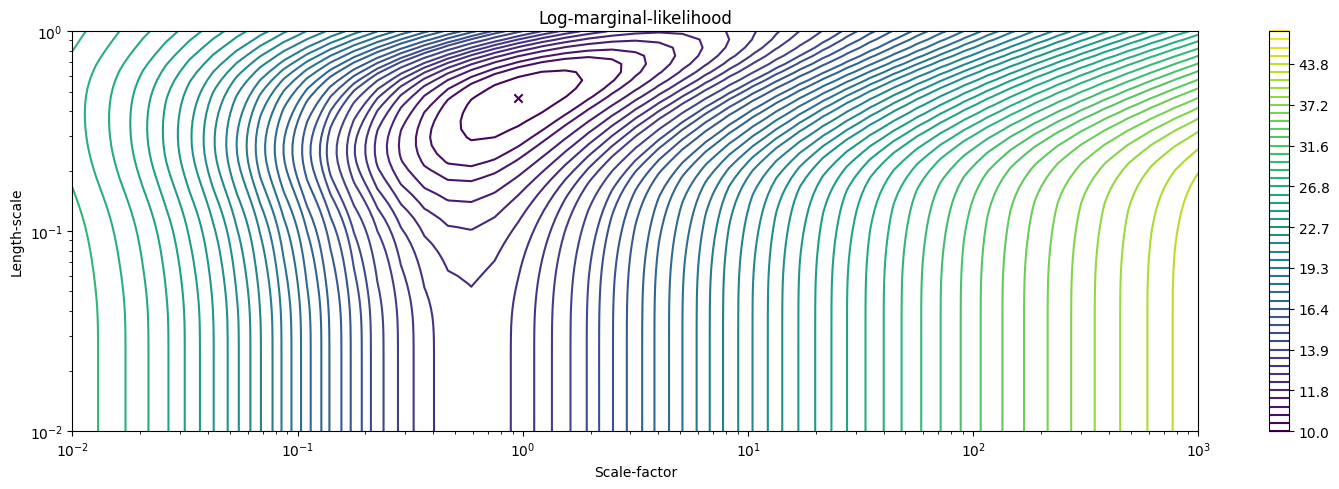

In [17]:
# TODO 7:
# We shall now compute the loss landscape (level curves) of the Log Marginal Likelihood (LML).

# Let's plot current kernel parameters:
print(f"Stored Kernel Parameters (Log-scale): {gp.kernel_.theta}")
print(f"Stored Kernel Parameters (linear scale): {np.exp(gp.kernel_.theta)}")
# The hyperparameters in linear scale can be obtained also in the following way:
# print(f"Kernel Parameters: {gp.kernel_.get_params()['k1__constant_value']}, {gp.kernel_.get_params()['k2__length_scale']}")

# Plot LML landscape
from matplotlib.colors import LogNorm
plt.figure(figsize=(15,5))
theta0 = np.logspace(-2, 3, 49)
theta1 = np.logspace(-2, 0, 50)
Theta0, Theta1 = np.meshgrid(theta0, theta1)

LML = []
for j in range(Theta0.shape[1]):
    LML_col = []
    for i in range(Theta0.shape[0]):
        # Compute the LML using sklearn (need to transform the values on the mesh grid using np.log)
        # Hint: have also a look at the function 'log_marginal_likelihood'
        # YOUR CODE HERE
        LML_col.append(gp.log_marginal_likelihood(np.log([Theta0[i, j], Theta1[i, j]])))
    LML.append(LML_col)

LML = np.array(LML).T

vmin, vmax = (-LML).min(), (-LML).max()
vmax = 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)
plt.contour(Theta0, Theta1, -LML,
            levels=level, norm=LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar()
plt.scatter(np.exp(gp.kernel_.theta)[0], np.exp(gp.kernel_.theta)[1], color='#440154ff', marker='x')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Scale-factor")
plt.ylabel("Length-scale")
plt.title("Log-marginal-likelihood")
plt.tight_layout()

c:\Users\Nihal\Documents\unipd\sem1\ml\MACHINE-LEARNING-2024-2025---INQ0091308---LABS\venv\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


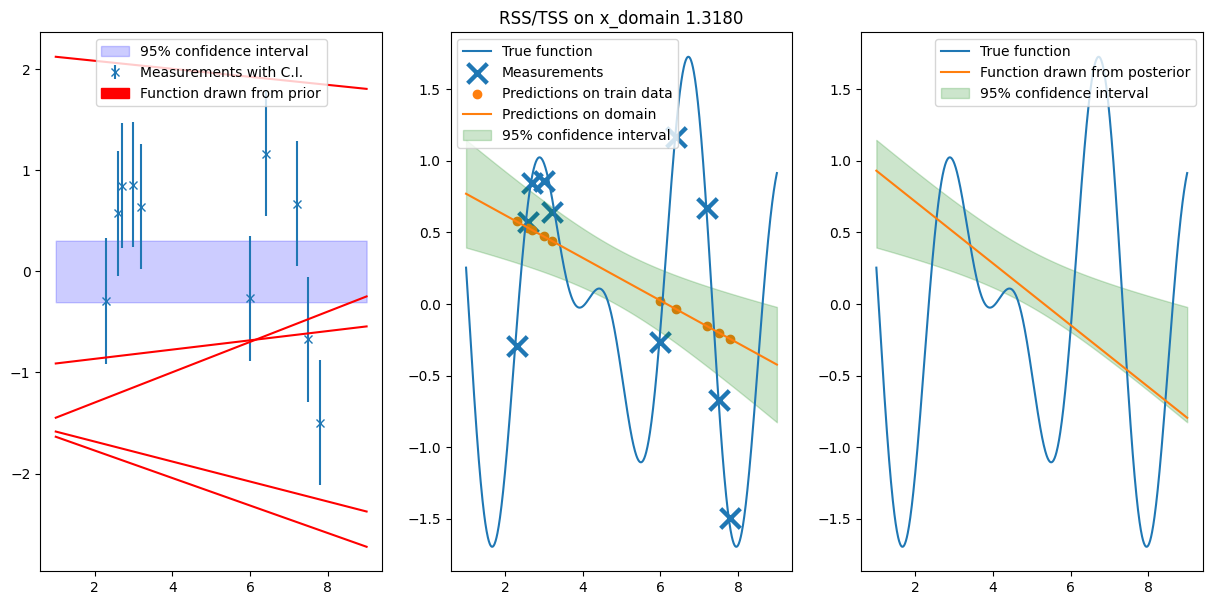

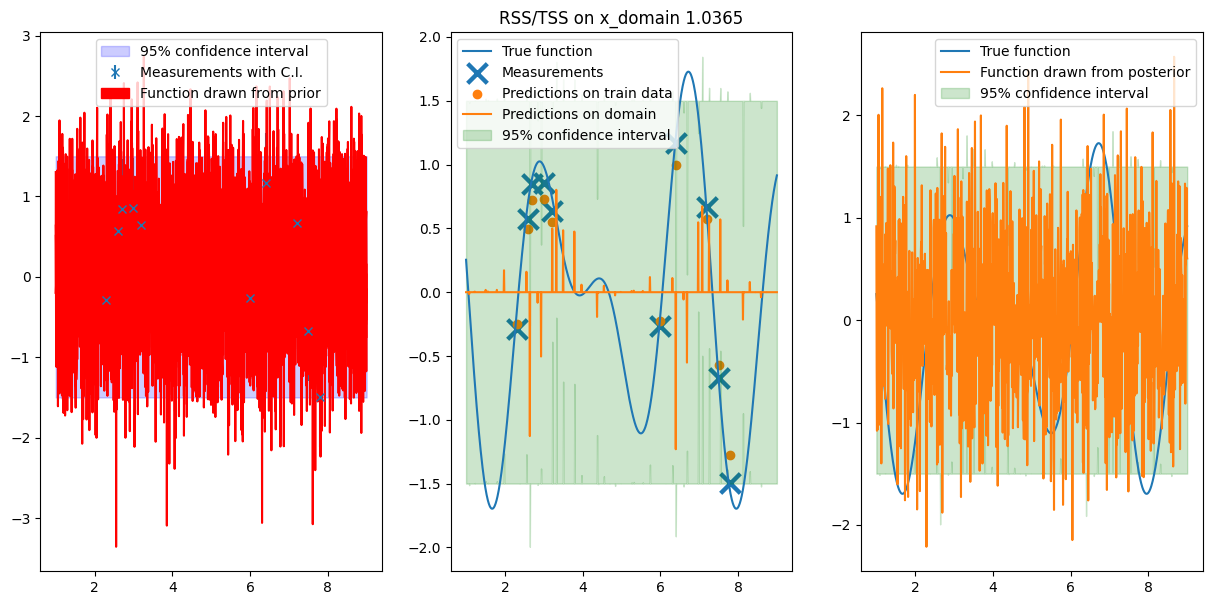

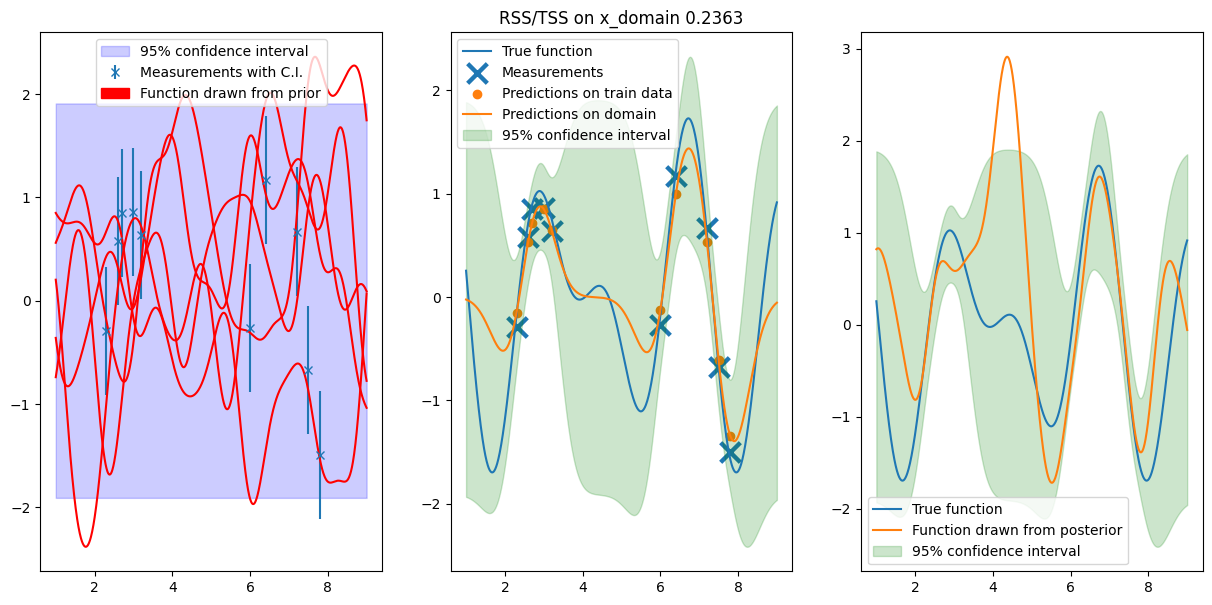

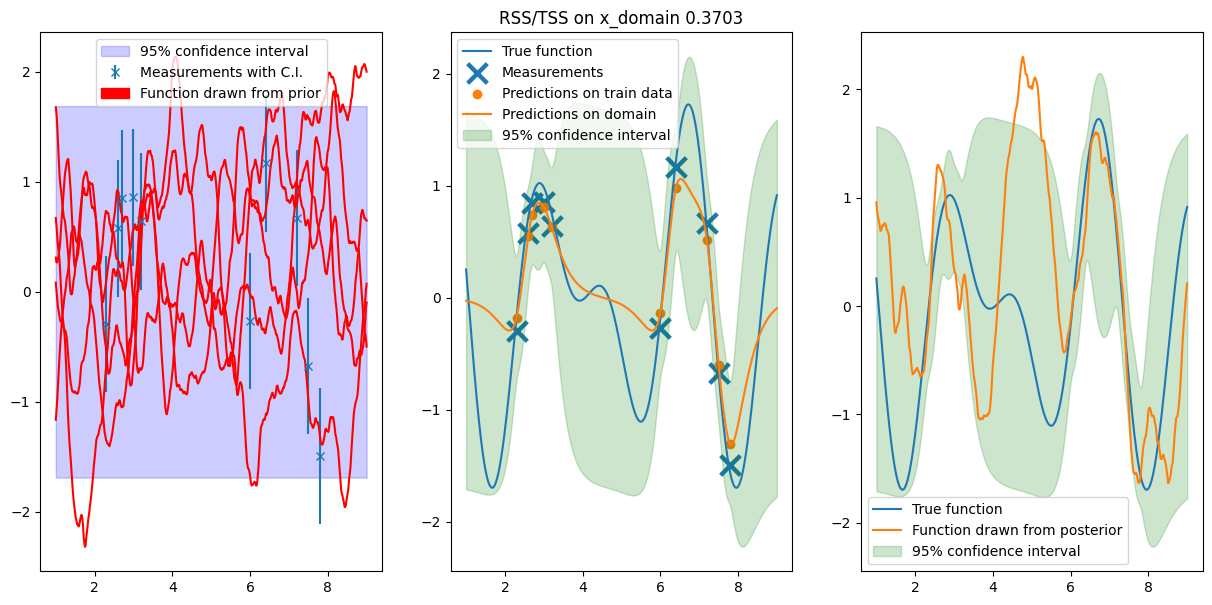

In [18]:
# TODO 8: Try different kernels from: https://scikit-learn.org/stable/modules/gaussian_process.html (sec 1.7.5)
# Use different kernels from sklearn documentation (e.g. DotProduct, ExpSineSquared, Matern, ...), find the best
# parameters optimizing the LML and then look at their approximation capability.
# Which is the best one? How do samples from posterior look like?

from sklearn.gaussian_process.kernels import *

scale_factor = 1
length_scale = 1
x_domain = np.linspace(1,9, 1000).reshape(-1,1)
y_domain_true = f(x_domain)

# Create DotProduct kernel (choose appropriate hyper parameters)
# YOUR CODE HERE
kernel = scale_factor * DotProduct()
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_2, optimizer='fmin_l_bfgs_b').fit(x_train, y_train)
plot_GP(gp, x_domain, y_domain_true)

# Create ExpSineSquared kernel (choose appropriate hyper parameters)
# YOUR CODE HERE
kernel = scale_factor * ExpSineSquared(length_scale=length_scale)
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_2, optimizer='fmin_l_bfgs_b').fit(x_train, y_train)
plot_GP(gp, x_domain, y_domain_true)

# Create RationalQuadratic kernel (choose appropriate hyper parameters)
# YOUR CODE HERE
kernel = scale_factor * RationalQuadratic(length_scale=length_scale)
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_2, optimizer='fmin_l_bfgs_b').fit(x_train, y_train)
plot_GP(gp, x_domain, y_domain_true)

# Create Matern kernel (choose appropriate hyper parameters)
# YOUR CODE HERE
kernel = scale_factor * Matern(length_scale=length_scale)
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_2, optimizer='fmin_l_bfgs_b').fit(x_train, y_train)
plot_GP(gp, x_domain, y_domain_true)